In [3]:
#Importing libraries
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [5]:
#Pulling the data
eth_data = yf.download('ETH-USD', start='2017-01-01', end='2022-01-01')
eth_df = pd.DataFrame(eth_data)

[*********************100%***********************]  1 of 1 completed


In [6]:
eth_df = eth_df.drop(columns=['Adj Close', 'Volume', 'Open', 'High', 'Low'])

In [8]:
eth_df.head()

,Close
Date,
2017-11-09,320.884003
2017-11-10,299.252991
2017-11-11,314.681000
2017-11-12,307.907990
2017-11-13,316.716003


In [9]:
short_window = 8
long_window = 21

In [10]:
# Generate the short and long moving averages (50 and 100 days, respectively)
eth_df['SMA8'] = eth_df['Close'].rolling(window=short_window).mean()
eth_df['SMA21'] = eth_df['Close'].rolling(window=long_window).mean()

# Prepopulate the `Signal` for trading
eth_df['Signal'] = 0.0


In [11]:
eth_df.dropna()

,Close,SMA8,SMA21,Signal
Date,,,,
2017-11-29,427.523010,448.014378,376.523430,0.0
2017-11-30,447.114014,456.322128,382.534383,0.0
2017-12-01,466.540009,463.368881,390.500432,0.0
2017-12-02,463.449005,461.936131,397.584622,0.0
2017-12-03,465.852997,461.883255,405.105813,0.0
...,...,...,...,...
2021-12-28,3800.893066,4019.675995,4002.442511,0.0
2021-12-29,3628.531738,3970.709961,3963.831741,0.0
2021-12-30,3713.852051,3937.179016,3944.500128,0.0


In [12]:
# Generate the trading signal 0 or 1,
# where 1 is when short-window (SMA50) is greater than the long (SMA 100)
# and 0 otherwise
eth_df['Signal'][short_window:] = np.where(
    eth_df['SMA8'][short_window:] > eth_df['SMA21'][short_window:], 1.0, 0.0
)

In [13]:
# Calculate the points in time when the Signal value changes
# Identify trade entry (1) and exit (-1) points
eth_df['Entry/Exit'] = eth_df['Signal'].diff()

# Review the DataFrame
eth_df.tail(10)

,Close,SMA8,SMA21,Signal,Entry/Exit
Date,,,,,
2021-12-23,4108.015625,3971.203583,4057.936907,0.0,0.0
2021-12-24,4047.982910,3981.892731,4049.711995,0.0,0.0
2021-12-25,4093.281006,4008.617035,4048.459310,0.0,0.0
2021-12-26,4067.328125,4021.925537,4042.221470,0.0,0.0
2021-12-27,4037.547607,4036.294922,4026.926723,1.0,1.0
2021-12-28,3800.893066,4019.675995,4002.442511,1.0,0.0
2021-12-29,3628.531738,3970.709961,3963.831741,1.0,0.0
2021-12-30,3713.852051,3937.179016,3944.500128,0.0,-1.0
2021-12-31,3682.632812,3884.006165,3933.744734,0.0,0.0


In [14]:
# Filling missing values with the previous ones
eth_df = eth_df.fillna(method ='pad')

In [16]:
eth_rnn = eth_df[['Close']]
eth_rnn

,Close
Date,
2017-11-09,320.884003
2017-11-10,299.252991
2017-11-11,314.681000
2017-11-12,307.907990
2017-11-13,316.716003
...,...
2021-12-28,3800.893066
2021-12-29,3628.531738
2021-12-30,3713.852051


In [17]:
 def window_data(df, window, feature_col_number, target_col_number):
    """
    This function accepts the column number for the features (X) and the target (y).
    It chunks the data up with a rolling window of Xt - window to predict Xt.
    It returns two numpy arrays of X and y.
    """
    X = []
    y = []
    for i in range(len(df) - window):
        features = df.iloc[i : (i + window), feature_col_number]
        target = df.iloc[(i + window), target_col_number]
        X.append(features)
        y.append(target)
    return np.array(X), np.array(y).reshape(-1, 1)

In [18]:
eth_rnn.isnull().sum()

Close    0
dtype: int64

In [20]:
# Define the window size
window_size = 30

# Set the index of the feature and target columns
feature_column = 0
target_column = 0

# Create the features (X) and target (y) data using the window_data() function.
X, y = window_data(eth_rnn, window_size, feature_column, target_column)

# Print a few sample values from X and y
print (f"X sample values:\n{X[:3]} \n")
print (f"y sample values:\n{y[:3]}")

X sample values:
[[320.88400269 299.25299072 314.68099976 307.9079895  316.71600342
  337.63101196 333.35699463 330.92401123 332.39401245 347.61199951
  354.38598633 366.73001099 360.40100098 380.65200806 410.16598511
  474.91101074 466.27600098 471.32998657 480.35501099 472.90200806
  427.52301025 447.11401367 466.54000854 463.44900513 465.85299683
  470.20401001 463.28100586 428.5880127  434.4079895  456.03100586]
 [299.25299072 314.68099976 307.9079895  316.71600342 337.63101196
  333.35699463 330.92401123 332.39401245 347.61199951 354.38598633
  366.73001099 360.40100098 380.65200806 410.16598511 474.91101074
  466.27600098 471.32998657 480.35501099 472.90200806 427.52301025
  447.11401367 466.54000854 463.44900513 465.85299683 470.20401001
  463.28100586 428.5880127  434.4079895  456.03100586 473.50201416]
 [314.68099976 307.9079895  316.71600342 337.63101196 333.35699463
  330.92401123 332.39401245 347.61199951 354.38598633 366.73001099
  360.40100098 380.65200806 410.16598511 47

In [21]:
# Manually splitting the data
split = int(0.7 * len(X))

X_train = X[: split]
X_test = X[split:]

y_train = y[: split]
y_test = y[split:]

In [22]:
# Importing the MinMaxScaler from sklearn
from sklearn.preprocessing import MinMaxScaler

# Create a MinMaxScaler object
scaler = MinMaxScaler()

# Fit the MinMaxScaler object with the features data X
scaler.fit(X_train)

# Scale the features training and testing sets
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Fit the MinMaxScaler object with the target data Y
scaler.fit(y_train)

# Scale the target training and testing sets
y_train = scaler.transform(y_train)
y_test = scaler.transform(y_test)

In [23]:
# Reshape the features data
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Print some sample data after reshaping the datasets
print (f"X_train sample values:\n{X_train[:3]} \n")
print (f"X_test sample values:\n{X_test[:3]}")

X_train sample values:
[[[0.18030149]
  [0.16381584]
  [0.175574  ]
  [0.17041208]
  [0.17712493]
  [0.19306489]
  [0.18980754]
  [0.18795329]
  [0.18907362]
  [0.20067171]
  [0.20583437]
  [0.21524212]
  [0.21041859]
  [0.22585249]
  [0.24834599]
  [0.29769013]
  [0.29110913]
  [0.29496092]
  [0.30183917]
  [0.29615901]
  [0.2615743 ]
  [0.2765052 ]
  [0.29131033]
  [0.28895459]
  [0.29078674]
  [0.29410278]
  [0.28882655]
  [0.26238597]
  [0.26682155]
  [0.28330111]]

 [[0.16381584]
  [0.175574  ]
  [0.17041208]
  [0.17712493]
  [0.19306489]
  [0.18980754]
  [0.18795329]
  [0.18907362]
  [0.20067171]
  [0.20583437]
  [0.21524212]
  [0.21041859]
  [0.22585249]
  [0.24834599]
  [0.29769013]
  [0.29110913]
  [0.29496092]
  [0.30183917]
  [0.29615901]
  [0.2615743 ]
  [0.2765052 ]
  [0.29131033]
  [0.28895459]
  [0.29078674]
  [0.29410278]
  [0.28882655]
  [0.26238597]
  [0.26682155]
  [0.28330111]
  [0.29661629]]

 [[0.175574  ]
  [0.17041208]
  [0.17712493]
  [0.19306489]
  [0.18980754

In [24]:
# Importing required Keras modules
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout


In [25]:
# Define the LSTM RNN model.
model = Sequential()

# Initial model setup

number_units = 30
dropout_fraction = 0.2

# Layer 1
model.add(LSTM(
    units=number_units,
    return_sequences=True,
    input_shape=(X_train.shape[1], 1))
    )
model.add(Dropout(dropout_fraction))

# Layer 2
model.add(LSTM(units=number_units, return_sequences=True))
model.add(Dropout(dropout_fraction))

# Layer 3
model.add(LSTM(units=number_units))
model.add(Dropout(dropout_fraction))

# Output layer
model.add(Dense(1))

In [26]:
# Compile the model
model.compile(optimizer="adam", loss="mean_squared_error")

In [27]:
# Show the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 30)            3840      
                                                                 
 dropout (Dropout)           (None, 30, 30)            0         
                                                                 
 lstm_1 (LSTM)               (None, 30, 30)            7320      
                                                                 
 dropout_1 (Dropout)         (None, 30, 30)            0         
                                                                 
 lstm_2 (LSTM)               (None, 30)                7320      
                                                                 
 dropout_2 (Dropout)         (None, 30)                0         
                                                                 
 dense (Dense)               (None, 1)                 3

In [28]:
# Train the model
model.fit(X_train, y_train, epochs=10, shuffle=False, batch_size=90, verbose=1)

Epoch 1/10
12/12 [==============================] - 11s 50ms/step - loss: 0.0625
Epoch 2/10
12/12 [==============================] - 1s 47ms/step - loss: 0.0207
Epoch 3/10
12/12 [==============================] - 1s 48ms/step - loss: 0.0077
Epoch 4/10
12/12 [==============================] - 1s 49ms/step - loss: 0.0060
Epoch 5/10
12/12 [==============================] - 1s 50ms/step - loss: 0.0077
Epoch 6/10
12/12 [==============================] - 1s 46ms/step - loss: 0.0115
Epoch 7/10
12/12 [==============================] - 1s 48ms/step - loss: 0.0060
Epoch 8/10
12/12 [==============================] - 1s 46ms/step - loss: 0.0055
Epoch 9/10
12/12 [==============================] - 1s 48ms/step - loss: 0.0051
Epoch 10/10
12/12 [==============================] - 1s 47ms/step - loss: 0.0050


In [29]:
# Evaluate the model
model.evaluate(X_test, y_test, verbose=0)

0.7765152454376221

In [30]:
# Make predictions using the testing data X_test
predicted = model.predict(X_test)

In [31]:
# Recover the original prices instead of the scaled version
predicted_prices = scaler.inverse_transform(predicted)
real_prices = scaler.inverse_transform(y_test.reshape(-1, 1))


In [32]:
# Create a DataFrame of Real and Predicted values
stocks = pd.DataFrame({
    "Actual": real_prices.ravel(),
    "Predicted": predicted_prices.ravel()
}, index = eth_rnn.index[-len(real_prices): ]) 

# Show the DataFrame's head
stocks.head()

,Actual,Predicted
Date,,
2020-10-13,381.190765,366.642639
2020-10-14,379.484039,367.264465
2020-10-15,377.441833,368.131866
2020-10-16,366.229004,369.327789
2020-10-17,368.855927,370.613159


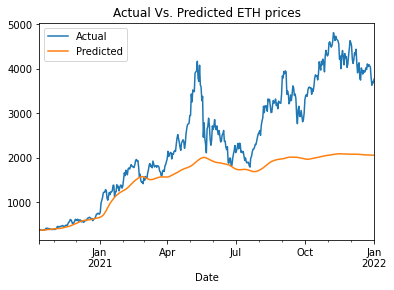

In [40]:
stocks.plot(title="Actual Vs. Predicted ETH prices")